Restructured file to do some stepping analysis with the exact mechanism.

This still uses the bins and grades setup which allows for ties between the mechanisms



In [1]:
### Standard Magic and startup initializers.

import math
import csv
import numpy as np
import random
import itertools
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter

_DEBUG = False

from peerselect import impartial
from peerselect import profile_generator

%matplotlib inline
matplotlib.style.use('bmh')

font = {'size'   : 14}

matplotlib.rc('font', **font)
np.set_printoptions(precision=3)

#random.seed(15)

class Impartial:
    VANILLA = "Vanilla"
    PARTITION = "Partition"
    EXACT = "ExactDollarPartition"
    DPR = "DollarPartitionRaffle"
    CREDIABLE = "CredibleSubset"
    RAFFLE = "DollarRaffle"
    ALL = (VANILLA, EXACT, PARTITION, RAFFLE, CREDIABLE, DPR)


# Exponential.
#scores = [pow(n, 4), pow(n, 3), pow(n, 2), n, 1]
#dist = [0.1, 0.2, 0.2, 0.2, 0.3]

#Borda
#scores = [3, 2, 1, 0]
#dist = [0.25, 0.25, 0.25, 0.25]

# Psuedo 10 point Normal... \sigma~=1
grades = ["A+", "A", "B+", "B", "C+", "C", "D+", "D", "F"]
scores = [8, 7, 6, 5, 4, 3, 2, 1, 0]
# Normal...
dist = [0.03, 0.05, 0.12, 0.15, 0.30, 0.15, 0.12, 0.05, 0.03]

s = 10

test_n = [130]
test_k = [25]
test_m = [10]
test_l = [3, 5, 8]
test_p = [0.1]

# test_n = [100]
# test_k = [20]
# test_m = [10, 15, 30, 50]
# test_l = [5]
# test_p = [0.1]


# Map for all Results.
results = {}
for n,k,m,l,p in itertools.product(test_n, test_k, test_m, test_l, test_p):
    
    # Compute some artifacts from the scoring distributions.
    agents = np.arange(0, n)
    
    #Bit Hacky but faster.... Generate a unanimous score matrix and compute some properties..
    t_profile = profile_generator.generate_mallows_mixture_profile(agents, agents, [1.0], [agents], [0.0])
    t_matrix = profile_generator.profile_classes_to_score_matrix(t_profile, scores, dist)
    
    #Determine how many of each bin we have.
    # Compute the binning from The SCORE MATRIX ---> Tally guy 0.
    t = Counter(list(t_matrix[:,0]))
    n_from_bin = [t[k] for k in sorted(t.keys(), reverse=True)]
    cum_n_from_bin = list(np.cumsum(n_from_bin))
    
    if _DEBUG: print("Bin Distro: " + str(n_from_bin))
    if _DEBUG: print("Cum. Distro: " + str(cum_n_from_bin))
    
    # Determine what bin they should go in according to the ground truth.
    # Just take the first guys's vector and iterate over it.
    # Guy i got score v and should be in the corresponding bin as indexed by the score vector.
    in_bin = {i:scores.index(v) for i,v in enumerate(list(t_matrix[:, 0]))}
    if _DEBUG: print("in")
    
    # Containers for Results
    #count_results = {x:[0]*k for x in Impartial.ALL}
    #per_sample_bin_results = []
    # Multilevel dict: {METHOD} --> {SAMPLE} --> [grade]
    grade_results = {m:{x:[0]*len(n_from_bin) for x in range(s)} for m in Impartial.ALL}
    for c_sample in range(s):
        #Generate a full profile and a clustering.
        profile = profile_generator.generate_mallows_mixture_profile(agents, agents, [1.0], [agents], [p])
        clustering = impartial.even_partition_order(sorted(agents, key=lambda j: random.random()), l)

        #Generate an approx-m-regular assignment.
        m_assignment = profile_generator.generate_approx_m_regular_assignment(agents, m, clustering, randomize=True)
        score_matrix = profile_generator.profile_classes_to_score_matrix(profile, scores, dist)
        score_matrix = profile_generator.restrict_score_matrix(score_matrix, m_assignment)

        #Compute Target Set.
        target_set = impartial.vanilla(score_matrix, k)
        
        # Capture the winning sets
        ws = {}
        # Let everyone else have the same size set so they are all compareable.
        ws[Impartial.VANILLA] = [i for i,j in impartial.vanilla(score_matrix, k)]
        
        # Let CRED, PART, and RAFFLE have bigger sets...
        ws[Impartial.EXACT] = impartial.exact_dollar_partition_explicit(score_matrix, k, clustering, normalize=True)
        ws[Impartial.PARTITION] = impartial.partition_explicit(score_matrix, k, clustering, normalize=False)
        ws[Impartial.CREDIABLE] = impartial.credible_subset(score_matrix, k, m, normalize=False)
        ws[Impartial.DPR] = impartial.dollar_raffle_explicit(score_matrix, k, clustering, normalize=True)
        #Call Raffle and have everyone in a cluster by themselves = Dollar.
        ws[Impartial.RAFFLE] = impartial.dollar_raffle(score_matrix, k, n, randomize=True, normalize=True)
                
        # Update the per bin picking for each type.
        for x in Impartial.ALL:
            for e in ws[x]:
                grade_results[x][c_sample][in_bin[e]] += 1
    
    # This should likely be some kind of multiindex but I can't figure it out.
    t = (n, k, m, l, p)
    results[t] = grade_results
    print("Finished: " + ",".join([str(x) for x in [n, k, m, l, p]]))
print("Done")

Finished: 130,25,10,3,0.1
Finished: 130,25,10,5,0.1
Finished: 130,25,10,8,0.1
Done


In [1]:
## Load some stuff from Pickle..
import pickle

## Open an older file
with open("./pickled_runs/variance_NSF1000s_130n_25k_5-15m_5l.pickle", 'rb') as input_file:
     results = pickle.load(input_file)

# Print the keys.
print("n, k, m, l, p, graph")
for k,v in results.items():
    print(k)
    
s=1000

n, k, m, l, p, graph
(130, 25, 15, 5, 0.1)
(130, 25, 10, 5, 0.1)
(130, 25, 5, 5, 0.1)


Min. for (n,k,m,l,$\phi$)=(130, 25, 10, 3, 0.1)
       ExactDollarPartition  Partition
grade                                 
0                  1.000000   1.000000
1                  0.909091   1.000000
2                  0.769231   0.769231
3                  0.521739   0.543478
4                  0.294118   0.294118
5                  0.238095   0.238095
6                  0.208333   0.208333
7                  0.196850   0.196850
8                  0.192308   0.192308
Mean for (n,k,m,l,$\phi$)=(130, 25, 10, 3, 0.1)
       ExactDollarPartition  Partition
grade                                 
0                  1.000000   1.000000
1                  0.981818   1.000000
2                  0.865385   0.888462
3                  0.541304   0.543478
4                  0.294118   0.294118
5                  0.238095   0.238095
6                  0.208333   0.208333
7                  0.196850   0.196850
8                  0.192308   0.192308
SD. for (n,k,m,l,$\phi$)=(130, 25, 10, 3, 0.1)

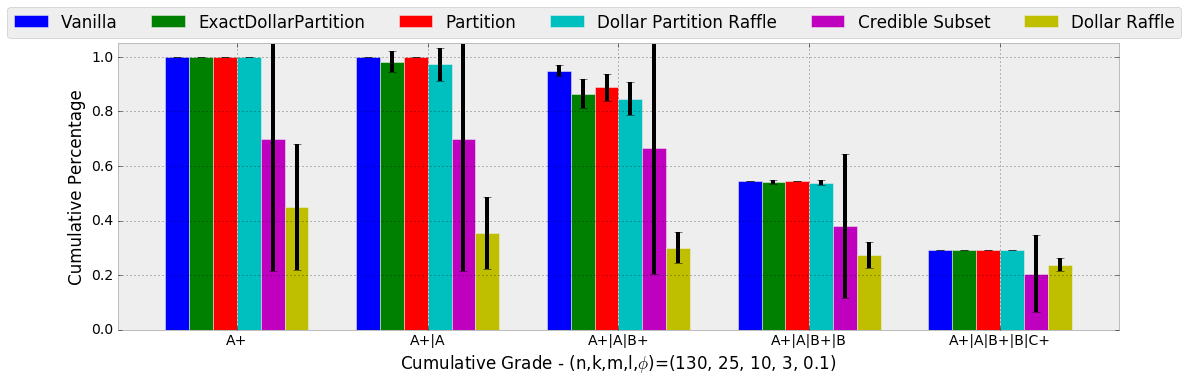

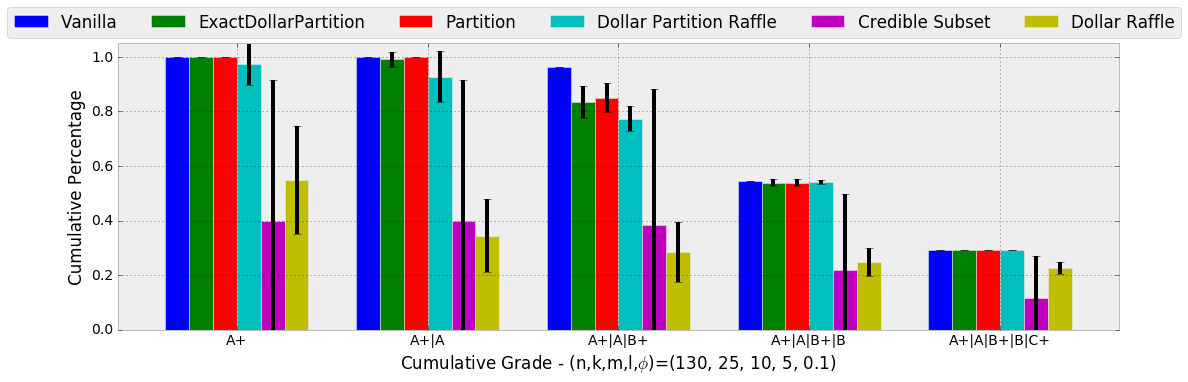

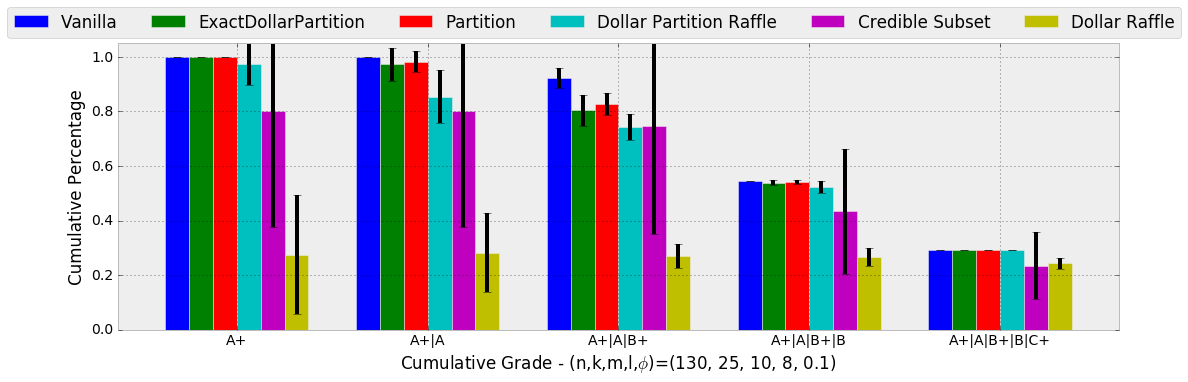

In [2]:
# Make Some Groovy Plots...

# Count everything up and make some graphs:
#print(grade_results)
cols = ["Vanilla", "ExactDollarPartition", "Partition", "DollarPartitionRaffle", "CredibleSubset", "DollarRaffle"]

# Build the proper multi-index of these things.
iterables = [list(range(s)), list(range(len(n_from_bin)))]
ix = pd.MultiIndex.from_product(iterables, names=["samlpes", "grade"])

### Build a cumulative version....
# Results is (big key) --> {Method} --> {Sample} --> {Grade}.  Process down each one.
# Multilevel dict: {METHOD} --> {SAMPLE} --> [grade]
all_df = {}
for k in results.keys():
    cum_bin = {m:{x:[0]*len(n_from_bin) for x in range(s)} for m in Impartial.ALL}
    for x in Impartial.ALL:
        for y in range(s):
            cum_bin[x][y] = np.cumsum(results[k][x][y])
            cum_bin[x][y] = [float(cum_bin[x][y][i]) / float(cum_n_from_bin[i]) for i in range(len(cum_bin[x][y]))]
    # For each top method...
    t = {}
    for c in results[k].keys():
        t[c] = list(itertools.chain.from_iterable(cum_bin[c].values()))

    # Build the same multiindex...
    all_df[k] = pd.DataFrame(t, index=ix)
    all_df[k] = all_df[k][cols]

#Rename the columns for this...
for i in all_df.keys():
    all_df[i].columns = ["Vanilla", "ExactDollarPartition", "Partition", "Dollar Partition Raffle", "Credible Subset", "Dollar Raffle"]

for i,k in enumerate(sorted(all_df.keys())):
    fig, axarr = plt.subplots(nrows=1, ncols=1)
    fig.set_size_inches(15, 5)
    gb = all_df[k].groupby(level=("grade"))
    gb.mean()[0:5].plot(kind="bar", yerr=gb.std(), ax=axarr, legend=False, 
        ylim=(0.0, 1.05), width=0.75, error_kw={'ecolor':'Black', 'linewidth':4, 'capsize':4})
    xa = axarr.get_xaxis()
    xa.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True)) 
    grades = ["", "A+", "A+|A", "A+|A|B+", "A+|A|B+|B", "A+|A|B+|B|C+", "C", "D+", "D", "F"]
    xa.set_ticklabels(grades, rotation='horizontal')
    axarr.set_xlabel("Cumulative Grade - (n,k,m,l,$\phi$)="+str(k))
    axarr.set_ylabel("Cumulative Percentage")
    plt.legend(bbox_to_anchor = (0,0.06,1,1), bbox_transform=plt.gcf().transFigure, loc='upper center', ncol=6, borderaxespad=0.)
    plt.tight_layout()
    
# Print Results

for k in sorted(all_df.keys()):
    gb = all_df[k].groupby(level=("grade"))
    print("Min. for (n,k,m,l,$\phi$)=" + str(k) + "\n" + str(gb["ExactDollarPartition", "Partition"].min()))
    print("Mean for (n,k,m,l,$\phi$)=" + str(k) + "\n" + str(gb["ExactDollarPartition", "Partition"].mean()))
    print("SD. for (n,k,m,l,$\phi$)=" + str(k) + "\n" + str(gb["ExactDollarPartition", "Partition"].std()))
    print("\n\n")
    

MultiIndex(levels=[['a', 'b'], ['bar', 'foo']],
           labels=[[0, 0, 0, 0, 1, 1, 1, 1], [1, 1, 0, 0, 1, 1, 0, 0]],
           names=['letter', 'word'])
             data1  data2
letter word              
a      foo       3      6
       foo       2      5
       bar       4      7
       bar       3      5
b      foo       2      4
       foo       4      5
       bar       3      6
       bar       2      5
{(4, 'C+'): [0, 1, 2, 3], (2, 'D+'): [0, 1, 2, 3], (1, 'A'): [0, 1, 2, 3], (1, 'A+'): [0, 1, 2, 3], (0, 'F'): [0, 1, 2, 3], (1, 'C'): [0, 1, 2, 3], (0, 'B+'): [0, 1, 2, 3], (3, 'C+'): [0, 1, 2, 3], (4, 'D+'): [0, 1, 2, 3], (2, 'C'): [0, 1, 2, 3], (0, 'D'): [0, 1, 2, 3], (4, 'C'): [0, 1, 2, 3], (0, 'A'): [0, 1, 2, 3], (0, 'C+'): [0, 1, 2, 3], (3, 'B+'): [0, 1, 2, 3], (3, 'D'): [0, 1, 2, 3], (4, 'A'): [0, 1, 2, 3], (3, 'D+'): [0, 1, 2, 3], (1, 'B+'): [0, 1, 2, 3], (1, 'C+'): [0, 1, 2, 3], (3, 'A+'): [0, 1, 2, 3], (3, 'C'): [0, 1, 2, 3], (2, 'F'): [0, 1, 2, 3], (3, 'B'): [0, 1, 2

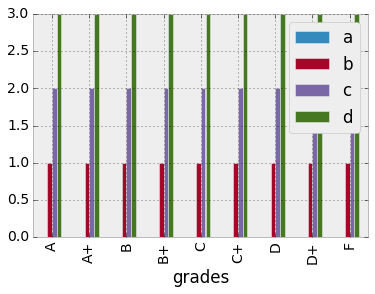

In [70]:
ix3 = pd.MultiIndex.from_arrays([['a', 'a', 'a', 'a', 'b', 'b', 'b', 'b'], ['foo', 'foo', 'bar', 'bar', 'foo', 'foo', 'bar', 'bar']], names=['letter', 'word'])

df3 = pd.DataFrame({'data1': [3, 2, 4, 3, 2, 4, 3, 2], 'data2': [6, 5, 7, 5, 4, 5, 6, 5]}, index=ix3)

print(ix3)
print(df3)

#iterables = [list(range(s)), grades]
#ix = pd.MultiIndex.from_product(iterables, names=["samlpes", "grade"])
#d = {x:{g:0 for g in grades} for x in range(s)}
#r = {x:{g:1 for g in grades} for x in range(s)}
#print(d)
# Tuples?
d = {}
for i in range(s):
    for k in grades:
        d[(i,k)] = [0, 1, 2, 3]

print(d)


#print(ix)
df4 = pd.DataFrame(d).T
df4.columns = ["a", "b", "c", "d"]
print(df4)
df4.index.names = ["samples", "grades"]
print(df4)

gb = df4.groupby(level=("grades"))
print(gb)
gb.mean().plot(kind="bar")

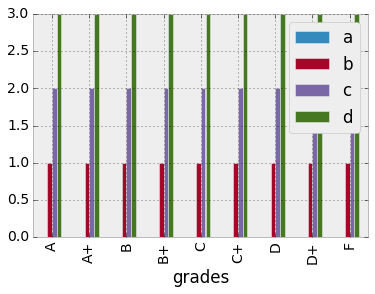

In [45]:
# Try to get a Box plot.. and a bar...


gb = df4.groupby(level=("grades"))
print(gb)
gb.mean().plot(kind="bar")



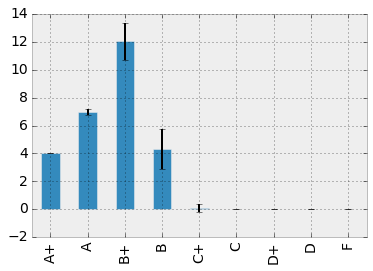

In [13]:
r.mean().plot(kind="bar", yerr=r.std())

In [10]:
# Try to save the results object for later...
import pickle

## Save the current runs
with open("./pickled_runs/NSF100s_even.pickle", 'wb') as output_file:
    pickle.dump(results, output_file)
    
## Open an older file
#with open("./pickled_runs/100s_130_NSF-Paper.pickle", 'rb') as input_file:
#     test = pickle.load(input_file)


KeyError: (130, 30, 10, 3, 0.1, 'cum_bin')

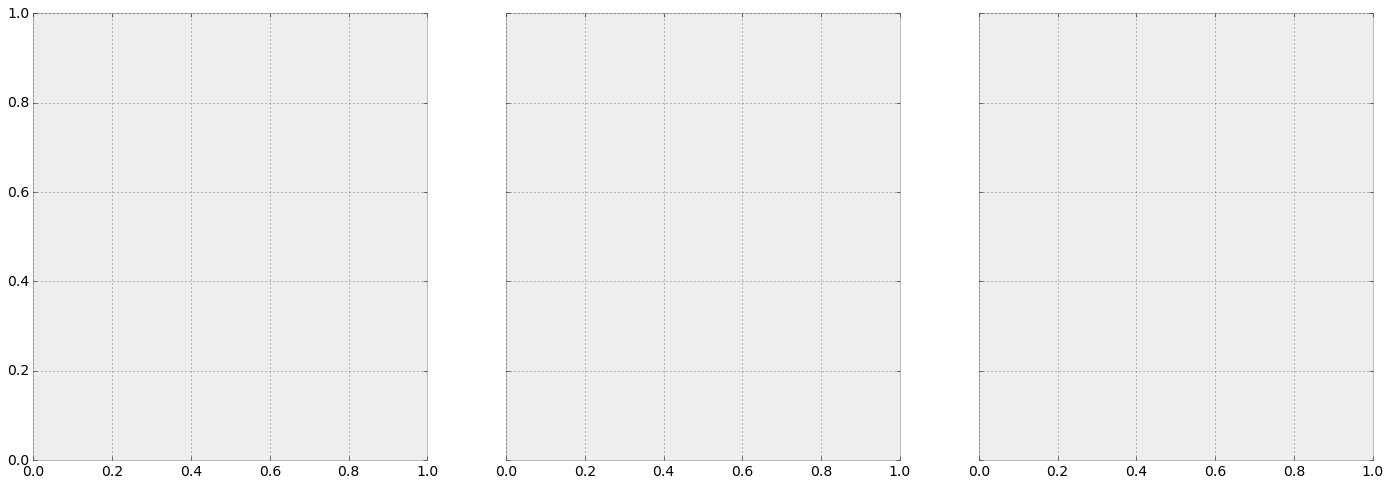

In [5]:
# This always assumes we're moving Phi around..

plot_results = results

labels = ["n", "k", "m", "l"]
# Index is an assignment to the above labels, type is one of count, cum_count, bin, cum_bin...
def plot_multi(index, t, x_label):
    fig, axarr = plt.subplots(nrows=1, ncols=3, sharey=True)
    fig.set_size_inches(24,8)
    for i,p in enumerate(test_p):
        plot_results[index + (p,t)].plot(ax=axarr[i], ylim=(0, 1.2), marker="*", \
            markersize=10, xlim=(-0.1, len(plot_results[index + (p,t)].index)*1.01), legend=False)
        axarr[i].set_title("$\phi=$"+str(p))
        xa = axarr[i].get_xaxis()
        xa.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))       
    axarr[0].set_ylabel("Percentage")
    axarr[1].set_xlabel(x_label)
    plt.suptitle("$n=" + str(index[0]) +
             "$, $k=" + str(index[1]) +
             "$, $m=" + str(index[2]) +
             "$, $l=" + str(index[3]) +"$ " + 
             "Scores: $" + str(scores) + "$, Num. Elements: $" + str(size) +"$", fontsize=20)
    plt.legend(bbox_to_anchor = (0,-0.08,1,1), bbox_transform=plt.gcf().transFigure, loc='upper center', ncol=6, borderaxespad=0.)
    # Save the Figure...
    plt.tight_layout()
    plt.subplots_adjust(top=0.80)
    #plt.savefig("k="+str(k)+"_m="+str(m)+"_l="+str(l)+".png",bbox_inches='tight')
    
plot_multi((130, 30, 10, 3), "cum_bin", "Cumulative Bin") 
plot_multi((130, 30, 10, 4), "cum_bin", "Cumulative Bin") 
plot_multi((130, 30, 10, 5), "cum_bin", "Cumulative Bin") 

plot_multi((130, 30, 10, 3), "cum_count", "Cumulative Count at Position") 
plot_multi((130, 30, 10, 4), "cum_count", "Cumulative Count at Position") 
plot_multi((130, 30, 10, 5), "cum_count", "Cumulative Count at Position") 

plot_multi((130, 30, 10, 3), "count", "Count at Position") 
plot_multi((130, 30, 10, 4), "count", "Count at Position") 
plot_multi((130, 30, 10, 5), "count", "Count at Position") 

plot_multi((130, 30, 10, 3), "bin", "Count at Bin") 
plot_multi((130, 30, 10, 4), "bin", "Count at Bin") 
plot_multi((130, 30, 10, 5), "bin", "Count at Bin") 

#labels = ["n"]
#print(results[(150, 25, 8, 5,0.1,'count')])





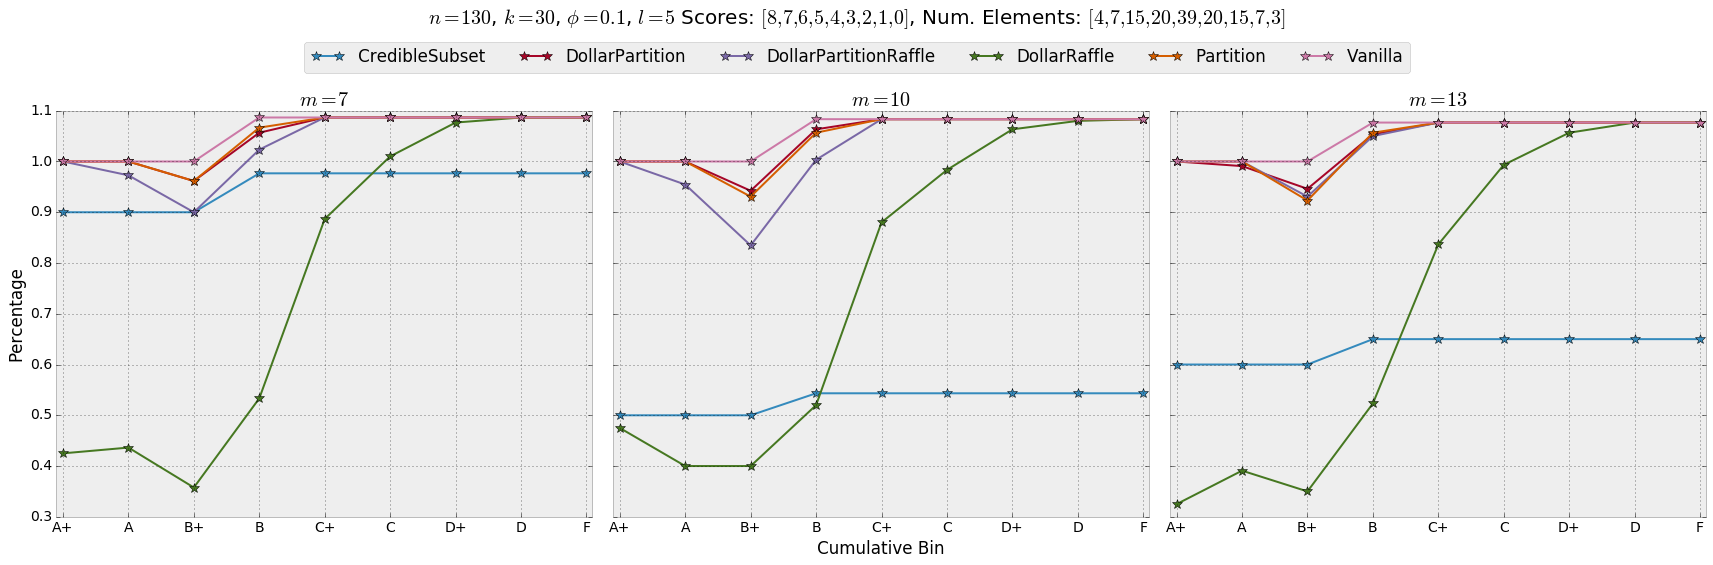

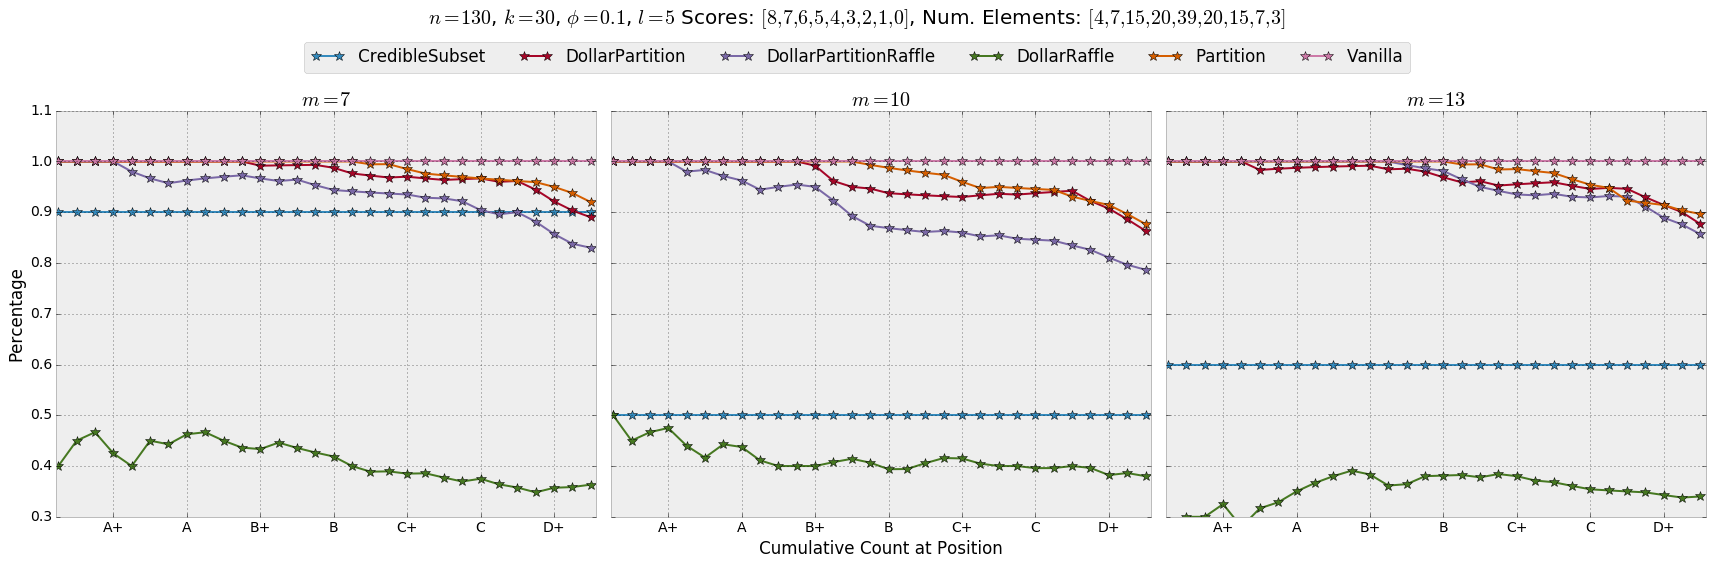

In [7]:
# Generate graphs that vary M at the top.

plot_results = results
x_labels = ["", "A+", "A", "B+", "B", "C+", "C", "D+", "D", "F"]

labels = ["n", "k", "m", "l"]
# Index is an assignment to the above labels, type is one of count, cum_count, bin, cum_bin...
def plot_multi(id1, id2, x_label):
    fig, axarr = plt.subplots(nrows=1, ncols=3, sharey=True)
    fig.set_size_inches(24,8)
    for i,m in enumerate(test_m):
        plot_results[id1 + (m, ) + id2].plot(ax=axarr[i], ylim=(0.3, 1.1), marker="*", \
            markersize=10, xlim=(0.90, len(plot_results[id1 + (m, ) + id2].index)*1.01), legend=False)
        axarr[i].set_title("$m="+str(m)+"$")
        xa = axarr[i].get_xaxis()
        xa.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True)) 
        xa.set_ticklabels(x_labels)
    axarr[0].set_ylabel("Percentage")
    axarr[1].set_xlabel(x_label)
    plt.suptitle("$n=" + str(id1[0]) +
             "$, $k=" + str(id1[1]) +
             "$, $\phi=" + str(id2[1]) +
             "$, $l=" + str(id2[0]) +"$ " + 
             "Scores: $" + str(scores) + "$, Num. Elements: $" + str(size) +"$", fontsize=20)
    plt.legend(bbox_to_anchor = (0,-0.08,1,1), bbox_transform=plt.gcf().transFigure, loc='upper center', ncol=6, borderaxespad=0.)
    # Save the Figure...
    plt.tight_layout()
    plt.subplots_adjust(top=0.80)
    #plt.savefig("k="+str(k)+"_m="+str(m)+"_l="+str(l)+".png",bbox_inches='tight')
    
plot_multi((130, 30), (5, 0.1, "cum_bin"), "Cumulative Bin")
plt.savefig("NSF-Bin.png",bbox_inches='tight')
plot_multi((130, 30), (5, 0.1, "cum_count"), "Cumulative Count at Position")
plt.savefig("NSF-Count.png",bbox_inches='tight')
#plot_multi((130, 30, 10, 4), "cum_bin", "Cumulative Bin") 
#plot_multi((130, 30, 10, 5), "cum_bin", "Cumulative Bin") 

#plot_multi((130, 30, 10, 3), "cum_count", "Cumulative Count at Position") 
#plot_multi((130, 30, 10, 4), "cum_count", "Cumulative Count at Position") 
#plot_multi((130, 30, 10, 5), "cum_count", "Cumulative Count at Position") 

#labels = ["n"]
#print(results[(150, 25, 8, 5,0.1,'count')])




In [1]:
fig, axarr = plt.subplots(nrows=2, ncols=3, sharey=True)
fig.set_size_inches(24,14)
for i,p in enumerate(df_counts.keys()):
    df_counts[p].plot(ax=axarr[0, i], ylim=(0, 1.1), marker="*", markersize=10, \
         xlim=(0.9, float(k)+0.1), legend=False)
    axarr[0, i].set_title("$\phi=$"+str(p))
    xa = axarr[0, i].get_xaxis()
    xa.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
    
    df_cum[p].plot(ax=axarr[1, i], ylim=(0, 1.1), marker="*", markersize=10, \
         xlim=(0.9, float(k)+0.1), legend=False)
    axarr[1, i].set_title("$\phi=$"+str(p))
    xa = axarr[1, i].get_xaxis()
    xa.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
#fig.legend()        
axarr[0, 0].set_ylabel("Percentage")
axarr[1, 0].set_ylabel("Percentage")
axarr[0, 1].set_xlabel("Vanilla Position")
axarr[1, 1].set_xlabel("Cumulative Vanilla Set")
plt.suptitle("Position Count (Top) and Cumulative Set Count (Bottom) with $n=" + str(n) +
         "$, $k=" + str(k) +
         "$, $m=" + str(m) +
         "$, $l=" + str(l) +"$.\n" + 
         "Scores: " + str(scores) + " Dist: " + str(dist) + " Size: " + str(size), fontsize=24)
plt.legend(bbox_to_anchor = (0,-0.09,1,1), bbox_transform=plt.gcf().transFigure, loc='upper center', ncol=4, borderaxespad=0.)

# Save the Figure...
plt.tight_layout()
plt.subplots_adjust(top=0.85)
#plt.savefig("k="+str(k)+"_m="+str(m)+"_l="+str(l)+".png",bbox_inches='tight')

NameError: name 'plt' is not defined

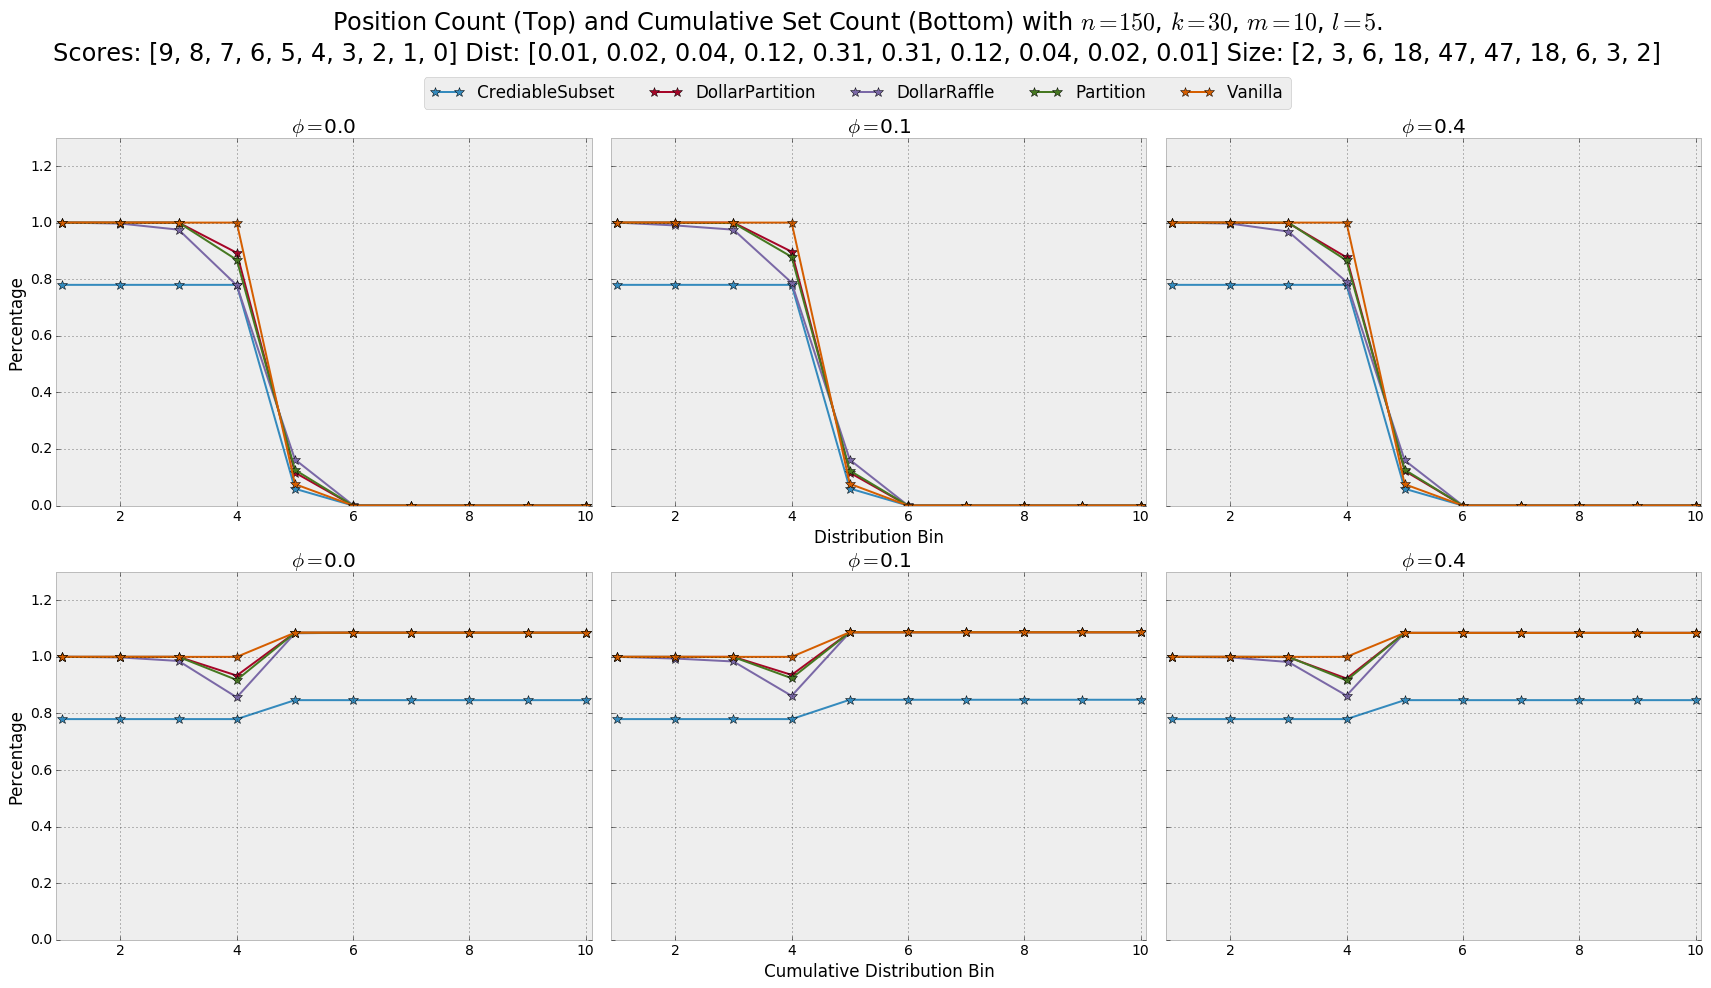

In [37]:
### Graph the Grouping results...

# df_cum_bins
# df_bins

fig, axarr = plt.subplots(nrows=2, ncols=3, sharey=True)
fig.set_size_inches(24,14)
for i,p in enumerate(df_bins.keys()):
    df_bins[p].plot(ax=axarr[0, i], ylim=(0, 1.1), marker="*", markersize=10, \
         xlim=(0.9, float(len(scores))+0.1), legend=False)
    axarr[0, i].set_title("$\phi=$"+str(p))
    xa = axarr[0, i].get_xaxis()
    xa.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
    
    df_cum_bins[p].plot(ax=axarr[1, i], ylim=(0, 1.3), marker="*", markersize=10, \
         xlim=(0.9, float(len(scores))+0.1), legend=False)
    axarr[1, i].set_title("$\phi=$"+str(p))
    xa = axarr[1, i].get_xaxis()
    xa.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
#fig.legend()        
axarr[0, 0].set_ylabel("Percentage")
axarr[1, 0].set_ylabel("Percentage")
axarr[0, 1].set_xlabel("Distribution Bin")
axarr[1, 1].set_xlabel("Cumulative Distribution Bin")
plt.suptitle("Position Count (Top) and Cumulative Set Count (Bottom) with $n=" + str(n) +
         "$, $k=" + str(k) +
         "$, $m=" + str(m) +
         "$, $l=" + str(l) +"$.\n" + 
         "Scores: " + str(scores) + " Dist: " + str(dist) + " Size: " + str(size), fontsize=24)
plt.legend(bbox_to_anchor = (0,-0.09,1,1), bbox_transform=plt.gcf().transFigure, loc='upper center', ncol=5, borderaxespad=0.)

# Save the Figure...
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.savefig("k="+str(k)+"_m="+str(m)+"_l="+str(l)+"-by_bin.png",bbox_inches='tight')